<center>
# TMA4215 Project 1
<center>

### Table of contents
#### 1. Introduction
#### 2. Algorithm 
#### 3. 

### 1. Introduction

### 2. Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from project_2_data_acquisition import generate_data, concatenate
from files import writeParams, readParams

In [106]:
def getW(K,d):
    w = np.random.randn(K,d,d)
    return w

def getb(K,d):
    b = np.random.randn(K,d,1)
    return b

def getomega(d):
    omega = np.random.randn(d,1)
    return omega

def getmu():
    mu = np.random.randn(1)
    return mu

In [119]:
def getZ(Y0, W, b, K, d, I, h, sigma):
    #initialize Z, Z0=Y0
    Z = np.zeros((K,d,I))
    Z[0] = Y0

    #finds Zk
    for k in range(1,K):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def getP(Z, ypsilon, c, omega, mu, W, b, K, d, I, h, sigma_div, eta_div):
    #initialize P
    P = np.zeros((K+1,d,I))

    #finds P_K
    u = np.transpose(Z[-1])@omega + mu
    P[-1]= omega@np.transpose((ypsilon-c)*eta_div(u))

    #finds P_K-1 to P_0
    for k in range(K-1,0,-1):
        s = W[k]@Z[k] + b[k]
        P[k]=P[k+1] + h*np.transpose(W[k])@(sigma_div(s)*P[k+1])
        
    return P


def getYpsilon(Z, omega, mu, K, eta):
    u = np.transpose(Z[K-1]) @ omega + mu
    return eta(u)

def getJ(ypsilon, c):
    return 1/2 * np.linalg.norm(ypsilon-c)**2

In [108]:
def getdJdmu(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K-1])@omega + mu
    dJdmu = np.transpose(eta_div(u))@(ypsilon-c)
    return dJdmu

def getdJdomega(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K-1])@omega + mu
    dJdOmega = Z[K-1] @ ((ypsilon - c) * eta_div(u))
    return dJdOmega

def getdJdW(P, Z, W, b, K, h, sigma_div):
    dJdW = np.zeros_like(W)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdW[k] = h*(P[k+1]*sigma_div(u))@ np.transpose(Z[k])  
    return dJdW

def getdJdb(P, Z, W, b, K, h, sigma_div):
    dJdb = np.zeros_like(b)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdb[k] = h*(P[k+1]*sigma_div(u))@np.ones((Z.shape[2],1))
    return dJdb

In [109]:
def getMandV(theta):
    return np.zeros_like(theta),np.zeros_like(theta)

def adam(m,v,g,i):
    #parameters
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.01
    epsilon = 10E-8

    #m,v
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*np.multiply(g,g)

    m_hat = np.multiply(m,1/(1-beta1**i))
    v_hat = np.multiply(v,1/(1-beta2**i))

    #update
    R = alpha*np.multiply(m_hat,1/(np.sqrt(v_hat)+epsilon))

    return m,v,R

In [110]:
def eta(x):
    return 1/2*(1+np.tanh(x/2))

def eta_div(x):
    return 1/(4*np.cosh(x/2)**2) 

def sigma(x):
    return np.tanh(x)

def sigma_div(x):
    return 1 - np.tanh(x)**2

In [111]:
def scale(x, alpha=0.2, beta=0.8):
    a = np.amin(x)
    b = np.amax(x)
    
    x_tilde = 1/(b-a)*((b-x)*alpha + (x-a)*beta)
    return x_tilde, a, b

def inverseScale(x_tilde, a, b, alpha=0.2, beta=0.8):
    return 1/(beta-alpha)*((x_tilde-alpha)*b + (beta-x_tilde)*a)

In [112]:
def successrate(ypsilon, c, tol):
    sum = 0
    for i in range(ypsilon.shape[0]):
        if isclose(ypsilon[i][0], c[0][i], abs_tol = tol):
            sum +=1
    return sum/ypsilon.shape[0]

In [120]:
def trainingAlgorithm(K, d, h, tau, Y0, c0, eta, sigma, eta_div, sigma_div, N, chunksize, optimization):
    #finds input shape
    d0 = Y0.shape[0]
    I0 = Y0.shape[1]
    
    #reshapes input to match dimension of layers
    if d0 > d:
        return "d must be larger than d0"
    
    if d0 < d:
        zero = np.zeros((d-d0,I0))
        Y0 = np.vstack((Y0,zero))
    
    #gets initial weigths
    omega = getomega(d)
    mu = getmu()
    W = getW(K,d)
    b = getb(K,d)
    
    c0 = np.transpose(c0)
  
    if optimization == "adam":
        #initial m,v for adam descent
        mmu,vmu = getMandV(mu)
        momega,vomega =getMandV(omega)
        mW,vW = getMandV(W)
        mb,vb = getMandV(b)
    
    #initializes vector to store objective function values
    J = np.zeros(N)
    ypsilon = np.zeros((chunksize,1))
    
    
    for i in range(N):
        
        #stochastic gradient descent
        if I0 == chunksize:
            Y0_chunk = Y0
            c_chunk = c0
        elif I0 > chunksize:
            s = np.random.randint(0,I0-chunksize)
            Y0_chunk = Y0[:,s:(s+chunksize)]
            c_chunk=c0[s:(s+chunksize),:]
        else:
            return "chunksize must be smaller than I"        
        

        #transformations between layers
        Z = getZ(Y0_chunk, W, b, K, d, chunksize, h, sigma)
        ypsilon = getYpsilon(Z, omega, mu, K, eta)
        P = getP(Z, ypsilon, c_chunk, omega, mu, W, b, K, d, chunksize, h, sigma_div, eta_div)
        
        #objective function
        J[i] = getJ(ypsilon, c_chunk)
        
        #finds gradients
        dJdmu = getdJdmu(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdomega = getdJdomega(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdW = getdJdW(P, Z, W, b, K, h, sigma_div)
        dJdb = getdJdb(P, Z, W, b, K, h, sigma_div)
        
        if optimization == "plain":
            mu = mu - tau*dJdmu
            omega = omega - tau*dJdomega
            W = W - tau*dJdW
            b = b - tau*dJdb
        
        elif optimization == "adam":
            mmu,vmu, Rmu = adam(mmu,vmu,dJdmu,i+1)
            momega,vomega, Romega = adam(momega,vomega,dJdomega,i+1)
            mW,vW, RW = adam(mW,vW,dJdW,i+1)
            mb,vb, Rb = adam(mb,vb,dJdb,i+1)

            #updates weights and biases
            mu = mu-Rmu
            omega = omega - Romega
            W = W - RW
            b = b - Rb
        
    return mu, omega, W, b, J, ypsilon

### 3. Testing with suggested functions

#### 3.1  F

In [12]:
#defines global variables
h = 0.1      #stepsize
tau = 0.01   #learning parameter

In [11]:
def F(y):
    return 1-np.cos(y)

In [121]:
N_F = 2500     #number of training series
K_F = 100      #number of hidden layers
d_F = 2      #dimension of layers for F(y)
I_F = 100      #input size 

#training with F(y)
Y0_F = np.linspace(-2,2,I_F)
Y0_F.resize(1,I_F)
c_F = F(Y0_F)

Y0_F_tilde, aY0_F, bY0_F = scale(Y0_F)
c_F_tilde, ac_F, bc_F = scale(c_F)

mu_F, omega_F, W_F, b_F, J_F, ypsilon_F = trainingAlgorithm(K_F, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N_F, I_F, "adam")

In [74]:
writeParams(W_F, b_F, omega_F, mu_F,ypsilon_F, filename = 'trainingParams_F.txt')

#OBSOBS VI MÅ LESE INN J_F OGSÅ!!

In [75]:
W_Fr,b_Fr,omega_Fr,mu_Fr,ypsilon_Fr = readParams(K_F, d_F, I_F, filename='trainingParams_F.txt')

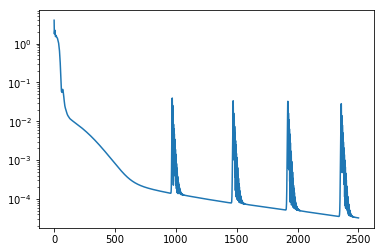

In [76]:
plt.plot(np.linspace(0,N_F,N_F), J_F)
plt.yscale('log')
plt.show()

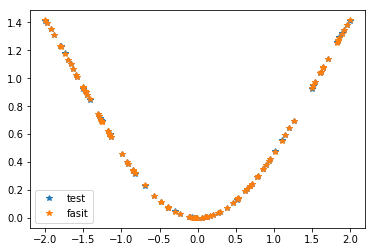

In [123]:
#testing with F(y)
YTest_F = np.random.uniform(-2,2,(1,I_F))
cTest_F = F(YTest_F)

YTest_F_tilde, aYTest_F, bYTest_F = scale(YTest_F)
cTest_F_tilde, acTest_F, bcTest_F = scale(cTest_F)

zero = np.zeros_like(YTest_F)

ZTest_F = getZ(np.vstack((YTest_F_tilde,zero)), W_Fr, b_Fr, K_F, d_F, I_F, h, sigma)
ypsilonTest_F_tilde = getYpsilon(ZTest_F, omega_Fr, mu_Fr, K_F, eta)


ypsilonTest_F = inverseScale(ypsilonTest_F_tilde, acTest_F, bcTest_F)

plt.figure()
plt.plot(YTest_F[0], ypsilonTest_F, "*", label = "test")
plt.plot(YTest_F[0], cTest_F[0], "*", label = "fasit")
plt.legend()
plt.show()

#### 3.2 G

In [37]:
def G(y1, y2):
    return 1/2 *(y1**2 + y2**2)

In [26]:
N_G = 2500     #number of training series
K_G = 100      #number of hidden layers
d_G = 4      #dimension of layers for F(y)
I_G = 100      #input size 

#training with G(y)
Y0_G = np.random.uniform(-2,2,(2,I_G))
c_G = G(Y0_G[0],Y0_G[1])
c_G.resize(1,I_G)

Y0_G_tilde, aY0_G, bY0_G = scale(Y0_G)
c_G_tilde, ac_G, bc_G = scale(c_G)

mu_G, omega_G, W_G, b_G, J_G, ypsilon_G = trainingAlgorithm(K_G, d_G, h, tau, Y0_G_tilde, c_G_tilde, eta, sigma, eta_div, sigma_div, N_G, I_G, "adam")

In [27]:
writeParams(W_G, b_G, omega_G, mu_G, ypsilon_G, filename = 'trainingParams_G.txt')

In [28]:
W_Gr,b_Gr,omega_Gr,mu_Gr, ypsilon_Gr = readParams(K_G, d_G, I_G, filename='trainingParams_G.txt')

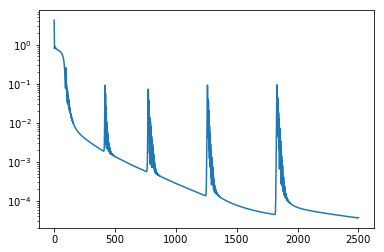

In [29]:
#plotting of objective function
plt.plot(np.linspace(0,N_G,N_G), J_G)
plt.yscale("log")
plt.show()

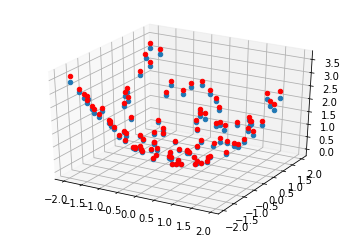

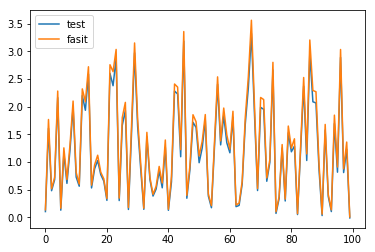

In [30]:
#testing with G(y)
YTest_G = np.random.uniform(-2,2,(2,I_G))
cTest_G = G(YTest_G[0], YTest_G[1])
cTest_G.resize(1,I_G)

YTest_G_tilde, aYTest_G, bYTest_G = scale(YTest_G)
cTest_G_tilde, acTest_G, bcTest_G = scale(cTest_G)

zero = np.zeros_like(YTest_G)

ZTest_G = getZ(np.vstack((YTest_G_tilde,zero)), W_G, b_G, K_G, d_G, I_G, h, sigma)
ypsilonTest_G_tilde = getYpsilon(ZTest_G, omega_G, mu_G, K_G, eta)


ypsilonTest_G = inverseScale(ypsilonTest_G_tilde, acTest_G, bcTest_G)


#plotting of G(y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(YTest_G[0], YTest_G[1], ypsilonTest_G, label = "test", depthshade = False)
ax.scatter(YTest_G[0], YTest_G[1], cTest_G[0], label = "test" , c="red", depthshade = False)
plt.show()

x = np.arange(0, I_G)
plt.plot(x, ypsilonTest_G, label ="test")
plt.plot(x, cTest_G[0], label = "fasit")
plt.legend()
plt.show()

### 4. Training with data given

In [31]:
d_0 = 3
N_0 = 3000
K_0= 150


batch0 = generate_data()

p0_tilde, ap0,bp0 = scale(batch0['P'])
T0_tilde, aT0, bT0 = scale(batch0['T'])
T0_tilde.resize(1,T0_tilde.shape[0])

I_0 = p0_tilde.shape[1]

mu_0, omega_0, W_0, b_0, J_0, ypsilon_0 = trainingAlgorithm(K_0, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N_0, "adam")

In [33]:
writeParams(W_0, b_0, omega_0, mu_0, ypsilon_0, filename = 'trainingParams_0.txt')

In [34]:
W_0r,b_0r,omega_0r,mu_0r,ypsilon_0r = readParams(K_0, d_0, I_0, filename='trainingParams_0.txt')

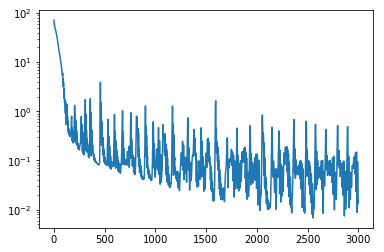

In [35]:
#plotting of objective function
plt.plot(np.linspace(0,N_0,N_0), J_0)
plt.yscale("log")
plt.show()

0.941162109375


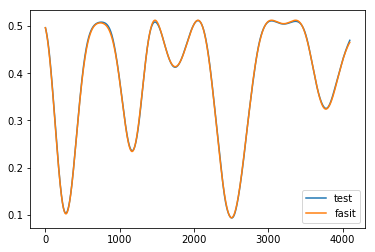

In [56]:
x = np.arange(0, I_0)
ypsilon0_scaled = inverseScale(ypsilon_0, aT0, bT0)
T0 = batch0['T']

print(successrate(ypsilon0_scaled, T0, 0.0035))

plt.plot(x, ypsilon0_scaled, label ="test")
plt.plot(x, T0[0], label = "fasit")
plt.legend()
plt.show()

In [61]:
#testing with batch 1

batch1 = generate_data(1)

p1_tilde, ap1,bp1 = scale(batch1['P'])
T1_tilde, aT1, bT1 = scale(batch1['T'])
T1_tilde.resize(1,T1_tilde.shape[0])


ZTest_1 = getZ(p1_tilde, W_0, b_0, K_0, d_0, I_0, h, sigma)
ypsilonTest_1_tilde = getYpsilon(ZTest_1, omega_0, mu_0, K_0, eta)


ypsilonTest_1 = inverseScale(ypsilonTest_1_tilde, aT1, bT1)

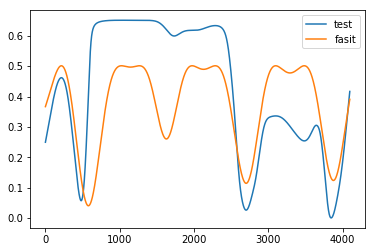

In [62]:
x = np.arange(0, I_0)
plt.plot(x, ypsilonTest_1, label ="test")
plt.plot(x, batch1["T"], label = "fasit")
plt.legend()
plt.show()